# Randomized Autoencoder Ensembles for Outlier Detection

In [12]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, roc_curve, roc_auc_score

Our plan is to look into using autoencoders for outlier detection and in particular, test randomized autoencoder ensembles against some standard methods (Elliptic Envelopes, LOF and Isolation Forests). The autoencoder model will be based on [Jinghui Chen, Saket Sathe, Charu Aggarwal, Deepak Turaga. Outlier Detection with Autoencoder Ensembles. SIAM SDM, 2017](https://saketsathe.net/downloads/autoencode.pdf):

- we will fit autoencoders and measure the degree of outlier-ness by the reconstruction loss;
- the autoencoders are fit on random samples of the data and connections in the neural nets are dropped randomly to increase diversity;
- we train the models using adaptive sampling, using more and more data as the training progresses;
- we score each data point by the median reconstruction loss of our ensemble.

## Data 

[ALOI data set](https://www.dbs.ifi.lmu.de/research/outlier-evaluation/DAMI/literature/ALOI/) for outlier detection downloaded from [here](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/OPQMVF). 

In [22]:
data = pd.read_csv("data/aloi-unsupervised-ad.csv", header=None)

data.columns = [f"feature_{i}" for i in range(data.shape[1]-1)] + ["outlier"]
data["outlier"] = np.where(data.outlier == "n", 0, 1)

data.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,outlier
0,0.872812,0.000005,0.0,0.000036,0.0,0.0,0.0,0.0,0.0,0.050327,...,0.014212,0.000104,0.0,0.025490,0.004937,0.000011,0.000054,0.006804,0.015385,1
1,0.975206,0.000000,0.0,0.000651,0.0,0.0,0.0,0.0,0.0,0.007039,...,0.000000,0.000000,0.0,0.004853,0.001582,0.000000,0.000000,0.000201,0.000000,1
2,0.963777,0.000000,0.0,0.002005,0.0,0.0,0.0,0.0,0.0,0.006642,...,0.000000,0.000000,0.0,0.007828,0.002523,0.000000,0.000393,0.003800,0.000000,1
3,0.973246,0.000000,0.0,0.000556,0.0,0.0,0.0,0.0,0.0,0.008979,...,0.000000,0.000000,0.0,0.004392,0.000170,0.000000,0.000000,0.000007,0.000000,1
4,0.960720,0.000000,0.0,0.000656,0.0,0.0,0.0,0.0,0.0,0.013319,...,0.000000,0.000000,0.0,0.010299,0.000561,0.000000,0.000084,0.000264,0.000000,1


In [26]:
X = data.drop("outlier", axis=1).values
y = data.outlier.values

y.mean()

0.03016

We will work with credit card data from [Wordline & ULB](https://www.kaggle.com/mlg-ulb/creditcardfraud).

In [2]:
data = pd.read_csv("data/creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
data.shape

(284807, 31)

In [4]:
X = data.drop(["Time", "Class"], axis=1).values
y = data["Class"].values

The proportion of outliers is around 0.17%:

In [5]:
y.mean()

0.001727485630620034

We will do just very basic preprocessing:

In [179]:
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

scaler_pipe = Pipeline([("robust", RobustScaler(quantile_range=(0.1, 0.9))),
                       ("minmax", MinMaxScaler(feature_range=(0, 1)))])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

X_train = scaler_pipe.fit_transform(X_train)
#X_val = scaler.transform(X_val)
X_test = scaler_pipe.transform(X_test)

y_train = y_train.reshape(-1, 1)
#y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [180]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((40000, 27), (40000, 1), (10000, 27), (10000, 1))

In [181]:
y_train.sum(), y_test.sum()

(1206, 302)

Before the modeling, we can visualize our data:

In [182]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_data = tsne.fit_transform(X_test[:5000])

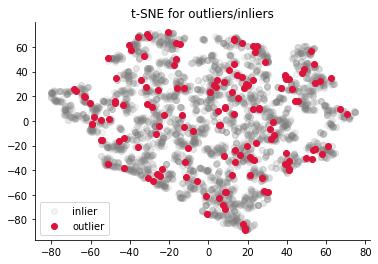

In [183]:
labels = y_test[:5000].reshape(-1)

plt.figure()
plt.scatter(tsne_data[labels == 0, 0], 
            tsne_data[labels == 0, 1], c="grey", alpha=0.1, label="inlier")
plt.scatter(tsne_data[labels == 1, 0], 
            tsne_data[labels == 1, 1], c="crimson", alpha=1, label="outlier")
plt.legend()
sns.despine()
plt.title("t-SNE for outliers/inliers")
plt.show()

## Outlier detection baselinesIsolationForest

We will use some [outlier detection baselines from sklearn](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_anomaly_comparison.html#sphx-glr-auto-examples-miscellaneous-plot-anomaly-comparison-py).

### Local Outlier Factors 

This is a non-parametric, density-based method that finds outliers by looking for data points which have significantly lower local densities then their neighbouring points. The rough algorithm is as follows:

1. Find the k-nearest neighbors and use the distance to estimate a local density;
2. Compare local densities with neighbours to detect outliers.

LOF being a distance-based method, it's important that our data is scaled. See more [here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html).

In [184]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=5, contamination=y_train.mean(), n_jobs=-1) # n_neighbours should be tuned

y_pred = lof.fit_predict(X_train) # 1: inlier, -1: outlier

In [185]:
cr = classification_report(y_train, np.where(y_pred == 1, 0, 1))
print(cr)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     38794
           1       0.18      0.18      0.18      1206

    accuracy                           0.95     40000
   macro avg       0.58      0.58      0.58     40000
weighted avg       0.95      0.95      0.95     40000



In [186]:
y_pred = lof.fit_predict(X_test) # 1: inlier, -1: outlier
cr = classification_report(y_test, np.where(y_pred == 1, 0, 1))
print(cr)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      9698
           1       0.12      0.12      0.12       302

    accuracy                           0.95     10000
   macro avg       0.55      0.55      0.55     10000
weighted avg       0.95      0.95      0.95     10000



### Elliptic Envelopes

Our second baseline is a paramteric method: by assuming that inlier data points are from a Gaussian distribution, we can measure the degree of outlier-ness by the fitted distribution. We perform a robust mean and covariance estimation (which should not be affected by outliers) and calculate the Mahalanobis distances to derive a measure of outlyingness. 

See more [here](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html#sklearn.covariance.EllipticEnvelope).

In [187]:
from sklearn.covariance import EllipticEnvelope

ee = EllipticEnvelope(contamination=y_train.mean(), support_fraction=0.9)
y_pred = ee.fit_predict(X_train)

/home/daniel/anaconda3/envs/deeplearning/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:171: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-307.191724716873637 > -308.646731540435781). You may want to try with a higher value of support_fraction (current value: 0.900).
  RuntimeWarning)
/home/daniel/anaconda3/envs/deeplearning/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:171: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-309.139593426890769 > -309.395235045531365). You may want to try with a higher value of support_fraction (current value: 0.900).
  RuntimeWarning)
/home/daniel/anaconda3/envs/deeplearning/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:171: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-305.608333924624844 > -306.307220834419809). You may want to try wi

In [188]:
cr = classification_report(y_train, np.where(y_pred == 1, 0, 1))
print(cr)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     38794
           1       0.03      0.03      0.03      1206

    accuracy                           0.94     40000
   macro avg       0.50      0.50      0.50     40000
weighted avg       0.94      0.94      0.94     40000



In [189]:
y_pred = ee.predict(X_test) # 1: inlier, -1: outlier
cr = classification_report(y_test, np.where(y_pred == 1, 0, 1))
print(cr)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      9698
           1       0.02      0.02      0.02       302

    accuracy                           0.94     10000
   macro avg       0.49      0.49      0.49     10000
weighted avg       0.94      0.94      0.94     10000



### Isolation Forest 

Lastly, another non-parametric method is the Isolation Forest. The idea is that a decision tree can isolate outlier data points (by splitting the data along features) by much shorter branches than inliers. We randomly select features and split values, recursively partitioning our data. The path length, averaged over a forest of such random trees, is a measure of inlier-ness: the longer the path the more regular the data point is.

See more [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest).

In [190]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(n_estimators=100, 
                                   contamination=y_train.mean(),
                                  )
y_pred = isolation_forest.fit_predict(X_train)

In [191]:
cr = classification_report(y_train, np.where(y_pred == 1, 0, 1))
print(cr)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     38794
           1       0.04      0.04      0.04      1206

    accuracy                           0.94     40000
   macro avg       0.51      0.51      0.51     40000
weighted avg       0.94      0.94      0.94     40000



In [192]:
y_pred = isolation_forest.predict(X_test) # 1: inlier, -1: outlier
cr = classification_report(y_test, np.where(y_pred == 1, 0, 1))
print(cr)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      9698
           1       0.03      0.03      0.03       302

    accuracy                           0.94     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       0.94      0.94      0.94     10000



## Randomized autoencoders

In [328]:
class RandAE(keras.Model):
    def __init__(self, input_dim, encoder_dims, drop_ratio=0.5, **kwargs):
        super(RandAE, self).__init__(**kwargs)
        
        self.input_dim = input_dim
        self.hidden_dims = encoder_dims
        self.drop_ratio = drop_ratio
        
        self.encoder, self.encoder_masks = self.get_encoder()
        self.decoder, self.decoder_masks = self.get_decoder()
        
    def get_mask(self, layer) -> np.ndarray:
        """
        Build mask for a layer.
        """
        
        shape = layer.input_shape[1], layer.output_shape[1]
        
        return np.random.choice([0., 1.], size=shape, p=[self.drop_ratio, 1-self.drop_ratio])
        
    def get_encoder(self) -> (keras.Model, np.ndarray):
        """
        Build the encoder with the connection masks.
        """
        
        encoder = keras.Sequential([layers.Input(self.input_dim, name="input")])
        encoder_masks = dict()
     
        for i, dim in enumerate(self.hidden_dims):
            activation = "relu" if i > 0 else "sigmoid"
            layer_name = f"encoder_hidden_{i}"
            layer = layers.Dense(dim, activation=activation, name=layer_name)
            encoder.add(layer)
            encoder_masks[layer_name] = self.get_mask(layer)
            
        return encoder, encoder_masks
    
    def get_decoder(self) -> (keras.Model, np.ndarray):
        """
        Build the decoder with the connection masks.
        """
        
        decoder = keras.Sequential([layers.Input(self.hidden_dims[-1])])
        decoder_masks = dict()
        decoder_dims = self.hidden_dims[:-1][::-1] + [self.input_dim]
        last_idx = len(decoder_dims) - 1 
        
        for i, dim in enumerate(decoder_dims):
            activation = "relu" if i < last_idx else "sigmoid"
            layer_name = f"decoder_hidden_{i}" if i < last_idx else "output"
            layer = layers.Dense(dim, activation=activation, name=layer_name)
            decoder.add(layer)
            
            # random mask except for output layer
            if i < last_idx:
                decoder_masks[layer_name] = self.get_mask(layer) 
        
        return decoder, decoder_masks
    
    def mask_weights(self) -> None:
        """
        Apply the masks to each layer in the encoder and decoder.
        """
        
        for model, masks in [(self.encoder, self.encoder_masks),
                             (self.decoder, self.decoder_masks)]:
            for layer in model.layers:
                layer_name = layer.name
                if layer_name in masks:
                    masked_w = layer.weights[0].numpy()*masks[layer_name]
                    b = layer.weights[1].numpy()
                    layer.set_weights((masked_w, b))
                    
    def call(self, data) -> tf.Tensor:
        
        # mask the weights before forward pass
        self.mask_weights()
        
        # encode-decode
        latent = self.encoder(data)
        output = self.decoder(latent)
        
        return output
    
    

## Training an ensemble

In [399]:
MODEL_PARAMS ={"input_dim": X_train.shape[1],
               "encoder_dims": [16, 8],
              "drop_ratio": 0.5}

COMPILE_PARAMS = {"optimizer": keras.optimizers.Adam(learning_rate=1e-3),
                 "loss": keras.losses.BinaryCrossentropy(),
                 "run_eagerly": True,}

TRAIN_PARAMS = {"epochs": 5,
                "batch_size": 128,
                "verbose": 1}

n_models = 5
ensemble = []

for i in range(n_models):
    model = RandAE(**MODEL_PARAMS)
    model.compile(**COMPILE_PARAMS)

    model.fit(X_train, 
              X_train,
              #validation_data=(X_test, X_test),
              **TRAIN_PARAMS
          )
    model.save_weights(f"models/randae_model_{i}")
    ensemble.append(model)

Epoch 1/5
313/313 [==============================] - 13s 40ms/step - loss: 0.4198
Epoch 2/5
313/313 [==============================] - 13s 41ms/step - loss: 0.0936
Epoch 3/5
313/313 [==============================] - 13s 40ms/step - loss: 0.0852
Epoch 4/5
313/313 [==============================] - 13s 41ms/step - loss: 0.0840
Epoch 5/5
313/313 [==============================] - 13s 42ms/step - loss: 0.0834
Epoch 1/5
313/313 [==============================] - 13s 41ms/step - loss: 0.1542
Epoch 2/5
313/313 [==============================] - 13s 41ms/step - loss: 0.0838
Epoch 3/5
313/313 [==============================] - 13s 43ms/step - loss: 0.0828
Epoch 4/5
313/313 [==============================] - 13s 41ms/step - loss: 0.0819
Epoch 5/5
313/313 [==============================] - 13s 40ms/step - loss: 0.0777
Epoch 1/5
313/313 [==============================] - 13s 42ms/step - loss: 0.1350
Epoch 2/5
313/313 [==============================] - 12s 39ms/step - loss: 0.0833
Epoch 3/5
313/31

In [400]:
# load models
ensemble = [RandAE(**MODEL_PARAMS) for i in range(n_models)]
for model in ensemble:
    model.load_weights(f"models/randae_model_{i}")
    model.compile(run_eagerly=True)

In [401]:
# make ensemble predictions
predictions = [model.predict(X_test) for model in ensemble]

In [402]:
reconstruction_loss = np.stack([np.square((pred - X_test)).mean(axis=1) for pred in predictions], axis=1)
median_loss = np.median(reconstruction_loss, axis=1)

threshold = np.quantile(median_loss, 1-y_train.mean())
test_outliers = np.where(median_loss > threshold, 1, 0)

In [403]:
cr = classification_report(y_test, test_outliers)
print(cr)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      9698
           1       0.04      0.04      0.04       302

    accuracy                           0.94     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       0.94      0.94      0.94     10000



## Latent manifold learning 

In [406]:
model = RandAE(input_dim=X_train.shape[1], encoder_dims=[16, 8, 4], drop_ratio=0)
model.compile(**COMPILE_PARAMS)

model.fit(X_train, 
          X_train,
          validation_data=(X_test, X_test),
          epochs=10,
          batch_size=32,
      )

Epoch 1/10
1250/1250 [==============================] - 68s 55ms/step - loss: 0.0889 - val_loss: 0.0775
Epoch 2/10
 233/1250 [====>.........................] - ETA: 51s - loss: 0.0783

KeyboardInterrupt: 

In [ ]:
latent = model.encoder.predict(X_test)

In [ ]:
tsne = TSNE(n_components=2)
tsne_data = tsne.fit_transform(latent[:5000])

In [ ]:
labels = y_test[:5000].reshape(-1)

plt.figure()
plt.scatter(tsne_data[labels == 0, 0], 
            tsne_data[labels == 0, 1], c="grey", alpha=0.1, label="inlier")
plt.scatter(tsne_data[labels == 1, 0], 
            tsne_data[labels == 1, 1], c="crimson", alpha=1, label="outlier")
plt.legend()
sns.despine()
plt.title("t-SNE for outliers/inliers on the latent manifold")
plt.savefig("outlier_tsne_latent.png")
plt.show()

## Baseline MLP classifier

We will train a baseline model to detect fraud.

In [404]:
base_model = keras.Sequential(
    [layers.Input(X.shape[1]),
    layers.Dense(16, activation="relu"),
    layers.Dense(8, activation="relu"),
    layers.Dense(1, activation="sigmoid")]
)

precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
auc = tf.keras.metrics.AUC()

base_model.compile(optimizer="adam", loss="binary_crossentropy",
                  metrics=[precision, recall, auc]
                  )

base_model.fit(x=X_train, 
               y=y_train,
               epochs=10,
               batch_size=128,
               #validation_data=(X_val, y_val)
          )

Epoch 1/10
313/313 [==============================] - 2s 6ms/step - loss: 0.3039 - precision_7: 0.0267 - recall_7: 0.0166 - auc_7: 0.5165
Epoch 2/10
313/313 [==============================] - 2s 5ms/step - loss: 0.1352 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - auc_7: 0.5122
Epoch 3/10
313/313 [==============================] - 2s 5ms/step - loss: 0.1341 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - auc_7: 0.5442
Epoch 4/10
313/313 [==============================] - 2s 5ms/step - loss: 0.1336 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - auc_7: 0.5588
Epoch 5/10
313/313 [==============================] - 2s 6ms/step - loss: 0.1334 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - auc_7: 0.5588
Epoch 6/10
313/313 [==============================] - 2s 6ms/step - loss: 0.1330 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - auc_7: 0.5627
Epoch 7/10
313/313 [==============================] - 2s 5ms/step - loss: 0.1325 - precision_7: 1.0000 - recall_7: 0.0017 - auc_7: 0

In [107]:
base_model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_57 (Dense)             (None, 29)                870       
_________________________________________________________________
dense_58 (Dense)             (None, 16)                480       
_________________________________________________________________
dense_59 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_60 (Dense)             (None, 1)                 9         
Total params: 1,495
Trainable params: 1,495
Non-trainable params: 0
_________________________________________________________________


              precision    recall  f1-score   support

           0       0.97      1.00      0.98      9698
           1       1.00      0.01      0.01       302

    accuracy                           0.97     10000
   macro avg       0.98      0.50      0.50     10000
weighted avg       0.97      0.97      0.96     10000



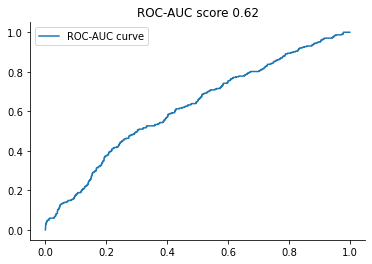

In [405]:
y_pred_prob = base_model.predict(X_test)
y_pred = np.where(y_pred_prob > 0.5, 1, 0)

from sklearn.metrics import classification_report, roc_curve, roc_auc_score

cr = classification_report(y_test, y_pred)
print(cr)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
rocauc = roc_auc_score(y_test, y_pred_prob)

plt.figure()
plt.plot(fpr, tpr, label="ROC-AUC curve")
plt.legend()
plt.title(f"ROC-AUC score {np.round(rocauc, 2)}")
sns.despine()
plt.show()

## Autoencoder pretraining 

In [210]:
encoder = keras.Sequential(
    [layers.Input(27),
    layers.Dense(16, activation="relu"),]
)

decoder = keras.Sequential(
    [layers.Dense(27, activation="linear")]
)

ae_model = keras.Sequential(
    [encoder, decoder]
)

In [211]:
ae_model.compile(optimizer="adam", loss=keras.losses.MeanSquaredError(),
                  metrics=["mse"]
                  )

ae_model.fit(x=X_train, 
             y=X_train,
             epochs=10,
             batch_size=128,
            # validation_data=(X_val, X_val)
          )

Epoch 1/10
313/313 [==============================] - 1s 2ms/step - loss: 0.0079 - mse: 0.0079
Epoch 2/10
313/313 [==============================] - 1s 2ms/step - loss: 9.6349e-04 - mse: 9.6349e-04
Epoch 3/10
313/313 [==============================] - 1s 2ms/step - loss: 4.8645e-04 - mse: 4.8645e-04
Epoch 4/10
313/313 [==============================] - 1s 2ms/step - loss: 3.5015e-04 - mse: 3.5015e-04
Epoch 5/10
313/313 [==============================] - 1s 2ms/step - loss: 2.8862e-04 - mse: 2.8862e-04
Epoch 6/10
254/313 [=======================>......] - ETA: 0s - loss: 2.3274e-04 - mse: 2.3274e-04

KeyboardInterrupt: 

In [ ]:
latent_data = encoder.predict(X_test[:10000])

tsne = TSNE(n_components=2)
tsne_data = tsne.fit_transform(latent_data)

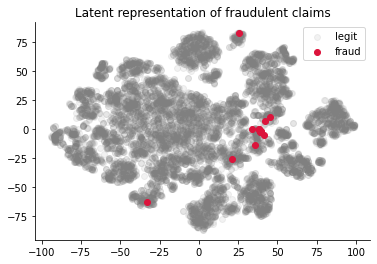

In [134]:
labels = y_test[:10000].reshape(-1)

plt.figure()
plt.scatter(tsne_data[labels == 0, 0], 
            tsne_data[labels == 0, 1], c="grey", alpha=0.1, label="legit")
plt.scatter(tsne_data[labels == 1, 0], 
            tsne_data[labels == 1, 1], c="crimson", alpha=1, label="fraud")
plt.legend()
sns.despine()
plt.title("Latent representation of fraudulent claims")
plt.show()

## Using the pretrained model to boost preformance

In [110]:
# copy encoder
pretrained_encoder = tf.keras.models.clone_model(encoder)

# freeze encoder layers -> we use the latent representations only 
for layer in pretrained_encoder.layers:
    layer.trainable = False

# add the same type of model and match the number of trainable parameters
pretrained_model = keras.Sequential(
    [pretrained_encoder, 
     layers.Dense(32, activation="relu"),
     layers.Dense(16, activation="relu"),
     layers.Dense(8, activation="relu"),
     layers.Dense(1, activation="sigmoid")]
)

pretrained_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                   loss="binary_crossentropy",
                   metrics=[precision, recall, auc]
                  )

pretrained_model.fit(x=X_train, 
                     y=y_train,
                     epochs=10,
                     batch_size=128,
                     validation_data=(X_val, y_val)
          )

Epoch 1/10
1425/1425 [==============================] - 7s 5ms/step - loss: 0.0766 - precision_14: 0.0317 - recall_14: 0.2386 - auc_14: 0.6939 - val_loss: 0.0049 - val_precision_14: 0.8095 - val_recall_14: 0.6456 - val_auc_14: 0.9091
Epoch 2/10
1425/1425 [==============================] - 5s 4ms/step - loss: 0.0053 - precision_14: 0.8718 - recall_14: 0.5397 - auc_14: 0.8997 - val_loss: 0.0044 - val_precision_14: 0.8387 - val_recall_14: 0.6582 - val_auc_14: 0.9228
Epoch 3/10
1425/1425 [==============================] - 7s 5ms/step - loss: 0.0049 - precision_14: 0.8517 - recall_14: 0.5651 - auc_14: 0.8984 - val_loss: 0.0053 - val_precision_14: 0.7632 - val_recall_14: 0.7342 - val_auc_14: 0.9268
Epoch 4/10
1425/1425 [==============================] - 7s 5ms/step - loss: 0.0047 - precision_14: 0.8832 - recall_14: 0.6000 - auc_14: 0.8982 - val_loss: 0.0044 - val_precision_14: 0.8182 - val_recall_14: 0.6835 - val_auc_14: 0.9287
Epoch 5/10
1425/1425 [==============================] - 8s 5ms/s

In [111]:
pretrained_model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_14 (Sequential)   (None, 8)                 1486      
_________________________________________________________________
dense_66 (Dense)             (None, 32)                288       
_________________________________________________________________
dense_67 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_68 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_69 (Dense)             (None, 1)                 9         
Total params: 2,447
Trainable params: 961
Non-trainable params: 1,486
_________________________________________________________________


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.82      0.60      0.69        98

    accuracy                           1.00     56962
   macro avg       0.91      0.80      0.85     56962
weighted avg       1.00      1.00      1.00     56962



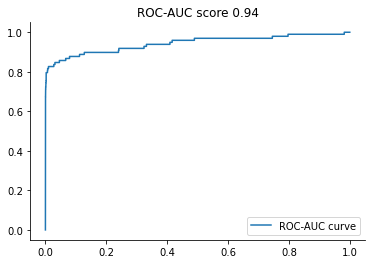

In [112]:
y_pred_prob = pretrained_model.predict(X_test)
y_pred = np.where(y_pred_prob > 0.5, 1, 0)

cr = classification_report(y_test, y_pred)
print(cr)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
rocauc = roc_auc_score(y_test, y_pred_prob)

plt.figure()
plt.plot(fpr, tpr, label="ROC-AUC curve")
plt.legend()
plt.title(f"ROC-AUC score {np.round(rocauc, 2)}")
sns.despine()
plt.show()

## Setup with insufficient labeled data

In [2]:
from sklearn.model_selection import train_test_split

In [8]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [9]:
# data spec
labeled_size = 1000
unlabeled_size = 10_000 
test_sample_size = 10_000

x_labeled = x_train[:labeled_size]
y_labeled = y_train[:labeled_size]

x_unlabeled = x_train[labeled_size:labeled_size+unlabeled_size]

x_test_sample = x_test[:test_sample_size]
y_test_sample = y_test[:test_sample_size]

x_labeled = np.expand_dims(x_labeled, -1).astype("float32") / 255
x_unlabeled = np.expand_dims(x_unlabeled, -1).astype("float32") / 255
x_test_sample = np.expand_dims(x_test_sample, -1).astype("float32") / 255

## Model construction 

In [10]:
latent_dim = 16

encoder_inputs = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
z = layers.Dense(latent_dim, activation="relu")(x)

encoder = keras.Model(encoder_inputs, z, name="encoder")
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                50192     
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________


In [11]:
latent_inputs = keras.Input(shape=(latent_dim,))

x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
dense_3 (Dense)              (None, 3136)              53312     
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 108,993
Trainable params: 108,993
Non-trainable params: 0
_____________________________________________________

In [12]:
ae_model = keras.Sequential()
ae_model.add(encoder)
ae_model.add(decoder)

In [13]:
ae_model

In [14]:
ae_model.compile(loss="mean_squared_error", 
                 optimizer="adam", 
                 metrics=["mean_squared_error"])

In [15]:
all_train = np.concatenate([x_labeled, x_unlabeled])

ae_model.fit(all_train, all_train,
             batch_size=128,
             epochs = 10)

Epoch 1/10
86/86 [==============================] - 30s 354ms/step - loss: 0.1051 - mean_squared_error: 0.1051
Epoch 2/10
86/86 [==============================] - 32s 375ms/step - loss: 0.0520 - mean_squared_error: 0.0520
Epoch 3/10
86/86 [==============================] - 30s 355ms/step - loss: 0.0276 - mean_squared_error: 0.0276
Epoch 4/10
86/86 [==============================] - 35s 406ms/step - loss: 0.0208 - mean_squared_error: 0.0208
Epoch 5/10
86/86 [==============================] - 33s 381ms/step - loss: 0.0184 - mean_squared_error: 0.0184
Epoch 6/10
86/86 [==============================] - 29s 341ms/step - loss: 0.0168 - mean_squared_error: 0.0168
Epoch 7/10
86/86 [==============================] - 26s 302ms/step - loss: 0.0158 - mean_squared_error: 0.0158
Epoch 8/10
86/86 [==============================] - 24s 283ms/step - loss: 0.0150 - mean_squared_error: 0.0150
Epoch 9/10
86/86 [==============================] - 25s 287ms/step - loss: 0.0144 - mean_squared_error: 0.0144
E

## Freeze the embedding and supervised train

In [18]:
for layer in encoder.layers:
    layer.trainable = False

In [19]:
classifier = keras.Sequential(
    [encoder,
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(10, activation="softmax")]
)

In [20]:
classifier.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Functional)         (None, 16)                69008     
_________________________________________________________________
dense_7 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_8 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_9 (Dense)              (None, 10)                170       
Total params: 69,722
Trainable params: 714
Non-trainable params: 69,008
_________________________________________________________________


In [21]:
classifier.compile(loss="sparse_categorical_crossentropy", 
                 optimizer="adam", 
                 metrics=["accuracy"])

classifier.fit(x_labeled, y_labeled, batch_size=32, epochs=30, verbose=1)

Epoch 1/30
32/32 [==============================] - 0s 7ms/step - loss: 3.7001 - accuracy: 0.1590
Epoch 2/30
32/32 [==============================] - 0s 7ms/step - loss: 2.5707 - accuracy: 0.2170
Epoch 3/30
32/32 [==============================] - 0s 8ms/step - loss: 2.1503 - accuracy: 0.2640
Epoch 4/30
32/32 [==============================] - 0s 7ms/step - loss: 1.9163 - accuracy: 0.3260
Epoch 5/30
32/32 [==============================] - 0s 7ms/step - loss: 1.7331 - accuracy: 0.3980
Epoch 6/30
32/32 [==============================] - 0s 7ms/step - loss: 1.5747 - accuracy: 0.4810
Epoch 7/30
32/32 [==============================] - 0s 9ms/step - loss: 1.4386 - accuracy: 0.5390
Epoch 8/30
32/32 [==============================] - 0s 9ms/step - loss: 1.3075 - accuracy: 0.5870
Epoch 9/30
32/32 [==============================] - 0s 9ms/step - loss: 1.1912 - accuracy: 0.6380
Epoch 10/30
32/32 [==============================] - 0s 8ms/step - loss: 1.0864 - accuracy: 0.6700
Epoch 11/30
32/32 [

In [22]:
y_pred = classifier.predict(x_test_sample)

In [23]:
y_pred.shape

(10000, 10)

In [24]:
from sklearn.metrics import classification_report

report = classification_report(y_test_sample, np.argmax(y_pred, axis=1))
print(report)

              precision    recall  f1-score   support

           0       0.90      0.93      0.92       980
           1       0.93      0.97      0.95      1135
           2       0.81      0.88      0.85      1032
           3       0.82      0.74      0.78      1010
           4       0.85      0.75      0.80       982
           5       0.73      0.73      0.73       892
           6       0.90      0.87      0.88       958
           7       0.86      0.84      0.85      1028
           8       0.84      0.75      0.79       974
           9       0.70      0.84      0.76      1009

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.84      0.83      0.83     10000



## Comparison with only supervised training 

In [25]:
encoder_inputs = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
z = layers.Dense(latent_dim, activation="relu")(x)

encoder = keras.Model(encoder_inputs, z, name="encoder")

base_classifier = keras.Sequential(
    [encoder,
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(10, activation="softmax")]
)

In [26]:
base_classifier.compile(loss="sparse_categorical_crossentropy", 
                 optimizer="adam", 
                 metrics=["accuracy"])

base_classifier.fit(x_labeled, y_labeled, batch_size=32, epochs=30, verbose=1)

Epoch 1/30
32/32 [==============================] - 1s 17ms/step - loss: 2.2036 - accuracy: 0.2060
Epoch 2/30
32/32 [==============================] - 1s 20ms/step - loss: 1.7128 - accuracy: 0.3770
Epoch 3/30
32/32 [==============================] - 1s 17ms/step - loss: 1.1058 - accuracy: 0.6340
Epoch 4/30
32/32 [==============================] - 1s 16ms/step - loss: 0.7696 - accuracy: 0.7310
Epoch 5/30
32/32 [==============================] - 1s 19ms/step - loss: 0.5729 - accuracy: 0.8210
Epoch 6/30
32/32 [==============================] - 0s 15ms/step - loss: 0.4356 - accuracy: 0.8800
Epoch 7/30
32/32 [==============================] - 0s 15ms/step - loss: 0.3331 - accuracy: 0.9090
Epoch 8/30
32/32 [==============================] - 0s 15ms/step - loss: 0.2705 - accuracy: 0.9290
Epoch 9/30
32/32 [==============================] - 1s 20ms/step - loss: 0.2526 - accuracy: 0.9280
Epoch 10/30
32/32 [==============================] - 1s 19ms/step - loss: 0.2211 - accuracy: 0.9450
Epoch 11/

In [27]:
y_pred = base_classifier.predict(x_test_sample)

report = classification_report(y_test_sample, np.argmax(y_pred, axis=1))
print(report)

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       980
           1       0.95      0.97      0.96      1135
           2       0.90      0.87      0.88      1032
           3       0.86      0.83      0.84      1010
           4       0.92      0.90      0.91       982
           5       0.80      0.88      0.84       892
           6       0.94      0.91      0.92       958
           7       0.84      0.90      0.87      1028
           8       0.88      0.78      0.83       974
           9       0.83      0.87      0.85      1009

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

